In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d robikscube/hourly-energy-consumption


Dataset URL: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
License(s): CC0-1.0
 44% 5.00M/11.4M [00:00<00:00, 47.5MB/s]
100% 11.4M/11.4M [00:00<00:00, 73.0MB/s]


In [3]:
!unzip hourly-energy-consumption.zip

Archive:  hourly-energy-consumption.zip
  inflating: AEP_hourly.csv          
  inflating: COMED_hourly.csv        
  inflating: DAYTON_hourly.csv       
  inflating: DEOK_hourly.csv         
  inflating: DOM_hourly.csv          
  inflating: DUQ_hourly.csv          
  inflating: EKPC_hourly.csv         
  inflating: FE_hourly.csv           
  inflating: NI_hourly.csv           
  inflating: PJME_hourly.csv         
  inflating: PJMW_hourly.csv         
  inflating: PJM_Load_hourly.csv     
  inflating: est_hourly.paruqet      
  inflating: pjm_hourly_est.csv      


                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1817/1817 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0277 - val_loss: 0.0116
Epoch 2/5
1817/1817 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0114 - val_loss: 0.0118
Epoch 3/5
1817/1817 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 4/5
1817/1817 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 5/5
1817/1817 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0113 - val_loss: 0.0111
908/908 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
MAE no conjunto de teste: 526.2747197047117


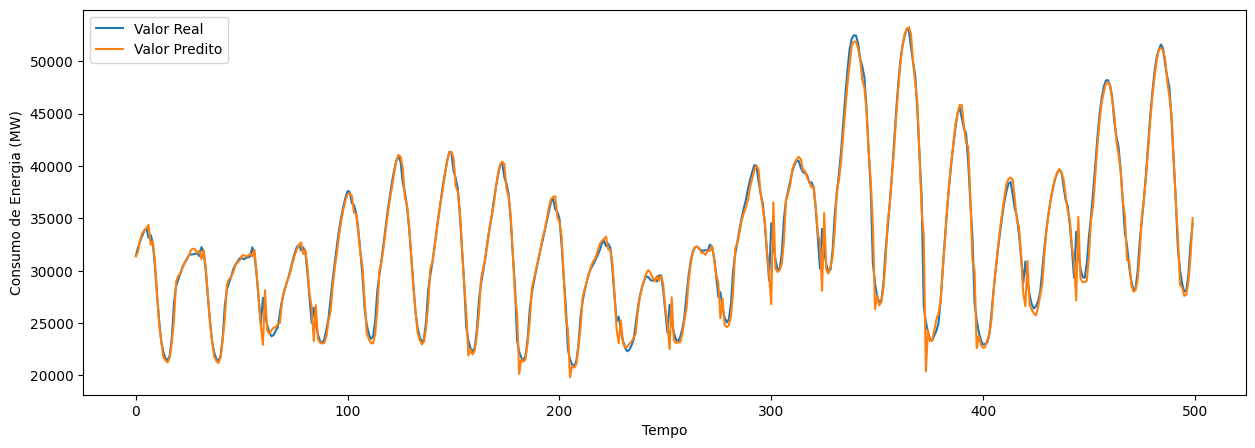

In [4]:
# Importar bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Carregar o dataset
data = pd.read_csv('PJME_hourly.csv', parse_dates=['Datetime'], index_col='Datetime')

# Visualizar as primeiras linhas do dataset
print(data.head())

# Selecionar a coluna de consumo e normalizar os dados
scaler = MinMaxScaler()
data['PJME_MW'] = scaler.fit_transform(data[['PJME_MW']])

# Dividir em conjunto de treinamento e teste
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Função para criar sequências de dados
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:i+seq_length].values
        y = data.iloc[i+seq_length].values[0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24  # Usando 24 horas anteriores
X_train, y_train = create_sequences(train[['PJME_MW']], seq_length)
X_test, y_test = create_sequences(test[['PJME_MW']], seq_length)

# Reshape para [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construir o modelo RNN
model = Sequential()
model.add(SimpleRNN(50, activation='tanh', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Fazer previsões
predictions = model.predict(X_test)

# Inverter a normalização
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_rescaled = scaler.inverse_transform(predictions)

# Avaliar o modelo usando MAE
mae = np.mean(np.abs(predictions_rescaled - y_test_rescaled))
print(f'MAE no conjunto de teste: {mae}')

# Plotar os resultados
plt.figure(figsize=(15,5))
plt.plot(y_test_rescaled[:500], label='Valor Real')
plt.plot(predictions_rescaled[:500], label='Valor Predito')
plt.xlabel('Tempo')
plt.ylabel('Consumo de Energia (MW)')
plt.legend()
plt.show()
